In [6]:
import cv2
import numpy as np
import numpy.matlib
import matlab.engine
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Reading Images

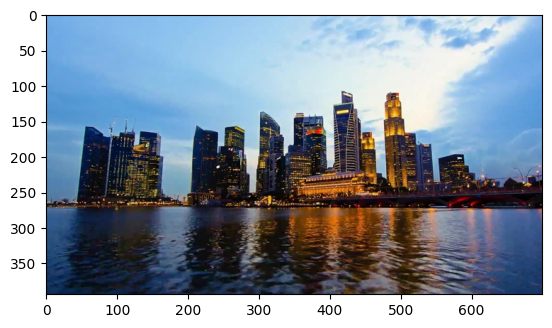

In [7]:
image = cv2.imread("singapore.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

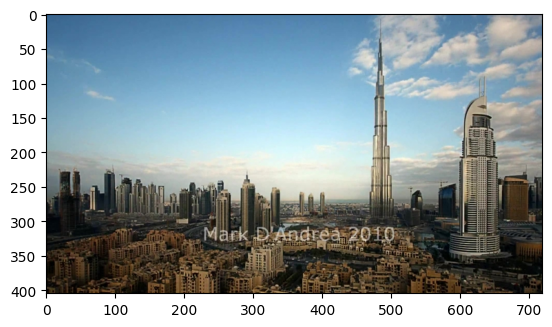

In [8]:
best_frame = cv2.imread("best_frame.jpg")
best_frame = cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB)
plt.imshow(best_frame)
plt.show()

# MRF Match

In [9]:
flags = {}
flags["patch_sz"] = 5
flags["overlap_sz"] = 4
flags["interval_sz"] = 1
flags["NN"] = 30
flags["patchDimL"] = 11
flags["num_training"] = 1
flags["isTemplateMatch"] = True
flags["sigma"] = 8
flags["half_band"] = 2
flags["num_norm"] = np.Inf
flags["num_iterations"] = 20
flags["epsilon"] = 0.008
flags["gamma"] = 1

In [10]:
def extractPatches(image, patch_sz, overlap_sz):
    gridPatch_sz = patch_sz
    height, width, channel = image.shape
    interval_sz = gridPatch_sz*2 - overlap_sz

    temp_x = np.arange(gridPatch_sz, width - gridPatch_sz, interval_sz)
    temp_y = np.arange(gridPatch_sz, height - gridPatch_sz, interval_sz)
    grid_xx, grid_yy = np.meshgrid(temp_x, temp_y)

    h, w = grid_xx.shape
    patchDim = patch_sz*2 + 1
    Patches = np.zeros((channel*(patchDim**2), h, w))
    Mask = Patches.copy()

    for i in range(h):
        for j in range(w):
            x0 = grid_xx[i, j]
            y0 = grid_yy[i, j]
            x1 = max(x0 - patch_sz, 0)
            x2 = min(x0 + patch_sz, width-1)
            y1 = max(y0 - patch_sz, 0)
            y2 = min(y0 + patch_sz, height-1)

            yl = patch_sz + y1 - y0
            yr = patch_sz + y2 - y0 + 1
            xl = patch_sz + x1 - x0
            xr = patch_sz + x2 - x0 + 1

            # Set Patch
            patch = np.zeros((patchDim, patchDim, channel))
            patch[yl:yr, xl:xr, :] = image[y1:y2+1, x1:x2+1, :]
            Patches[:, i, j] = patch.ravel('F')

            # Set Mask
            mask = np.zeros((patchDim, patchDim, channel))
            mask[yl:yr, xl:xr, :] = 1
            Mask[:, i, j] = mask.ravel('F')
    
    return Patches, Mask

In [11]:
def im2patches(image, patch_sz, interval_sz, mask, boundary_sz):
  temp = np.arange(-patch_sz, patch_sz+1)

  p_xx, p_yy = np.meshgrid(temp, temp)
  nDim = p_xx.size

  height, width = image.shape
  temp_x = np.arange(boundary_sz, width-boundary_sz, interval_sz)
  temp_y = np.arange(boundary_sz, height-boundary_sz, interval_sz)
  grid_xx, grid_yy = np.meshgrid(temp_x, temp_y)

  grid_xx = grid_xx.ravel('F')
  grid_yy = grid_yy.ravel('F')

  nPatches = grid_xx.size

  temp_x = p_xx.ravel('F')
  temp_y = p_yy.ravel('F')

  xx = np.matlib.repmat(temp_x, nPatches, 1) + np.matlib.repmat(grid_xx, nDim, 1).T
  yy = np.matlib.repmat(temp_y, nPatches, 1) + np.matlib.repmat(grid_yy, nDim, 1).T

  xx = xx.ravel('F')
  yy = yy.ravel('F')
  arr = np.array([yy, xx])

  index = np.ravel_multi_index(arr, (height, width), order='F')
  temp_img = image.flatten('F')
  patches = temp_img[index]
  patches = patches.reshape(nPatches, nDim, order='F')

  return patches


In [12]:
def im2patchesN(image, patch_sz, interval_sz):
  h, w, c = image.shape
  boundary_sz = patch_sz
  mask = []

  foo = im2patches(image[:, :, 0], patch_sz, interval_sz, mask, boundary_sz)
  nh, num_samples = foo.shape

  patches = im2patches(image[:, :, 0], patch_sz, interval_sz, mask, boundary_sz)
  patch = im2patches(image[:, :, 1], patch_sz, interval_sz, mask, boundary_sz)
  patches = np.hstack((patches, patch))
  patch = im2patches(image[:, :, 2], patch_sz, interval_sz, mask, boundary_sz)
  patches = np.hstack((patches, patch))

  return patches

In [13]:
def im2patches3(image, patch_sz, interval_sz):

  boundary_sz = patch_sz
  mask = []

  patches_r = im2patches(image[:, :, 0], patch_sz, interval_sz, mask, boundary_sz)
  patches_g = im2patches(image[:, :, 1], patch_sz, interval_sz, mask, boundary_sz)
  patches_b = im2patches(image[:, :, 2], patch_sz, interval_sz, mask, boundary_sz)

  return np.hstack((patches_r, patches_g, patches_b))

In [14]:
def SearchCandidates(Patches, Mask, dictionary_lowres, im_best_manifolds, flags):
  
  best_manifolds = im_best_manifolds.copy()
  best_manifolds = best_manifolds.astype(np.float32)
  
  NN = flags["NN"]
  patchDimL = flags["patchDimL"]
  num_training = flags["num_training"]
  interval_sz = flags["interval_sz"]
  sigma = flags["sigma"]

  _, _, num_channel = best_manifolds.shape
  dim, h, w = Patches.shape
  nSamples = dictionary_lowres.shape[0]

  candidates = []
  for i in range(h):
    dictlist = [{'idx': np.zeros((NN, 1)), 'patches': np.zeros((num_channel*(patchDimL**2), 1))} for j in range(w)]
    candidates.append(dictlist)

  for i in range(h):
    idx = []
    for j in range(w):
      Dist = []
      if (flags["isTemplateMatch"] == True):
        patch = Patches[:, i, j]
        patch = np.reshape(patch, (patchDimL, patchDimL, num_channel), order='F')
        patch = patch.astype(np.float32)

        for l in range(num_training):
          cost_map = cv2.matchTemplate(best_manifolds, patch, cv2.TM_SQDIFF)
          query_y_coordinate = i/h
          lower_pass_bound = query_y_coordinate - flags["half_band"];
          upper_pass_bound = query_y_coordinate + flags["half_band"];
          cost_map_height = cost_map.shape[0]
          
          penalty = np.zeros(cost_map.shape)

          if (lower_pass_bound > 0):
            penalty[0 : 1 + np.ceil(lower_pass_bound*cost_map_height), :] = np.Inf

          if (upper_pass_bound < 1):
            penalty[np.ceil(lower_pass_bound*cost_map_height) - 1:, :] = np.Inf

          cost_map = cost_map + penalty
          Dist = cost_map
          
        Dist = Dist.ravel(order='F')

      temp = Dist/2
      temp = temp/(patchDimL**2)
      temp = temp/(sigma**2)

      prob_dis = np.exp(-temp)
      prob_dis = prob_dis/np.sum(prob_dis)

      sampled_idx = np.random.choice(np.arange(Dist.size), NN, True, prob_dis)
      candidate_dist=Dist[sampled_idx];
      candidate_order = np.argsort(candidate_dist)
      idx = sampled_idx[candidate_order]

      candidates[i][j]['idx'] = idx
      
  return candidates

In [15]:
def k_candidates(image, best_frame, flags):
  
  patch_sz=flags["patch_sz"]
  overlap_sz=flags["overlap_sz"]
  interval_sz=flags["interval_sz"]

  best_frame_patches = im2patchesN(best_frame, patch_sz, interval_sz)
  Patches, Mask = extractPatches(image, patch_sz, overlap_sz)
  dim, h, w = Patches.shape
  candidates = SearchCandidates(Patches, Mask, best_frame_patches, best_frame, flags)

  for i in range(h):
    for j in range(w):
      candidates[i][j]['optimal_idx'] = 1

  return candidates, 'patch_candidates', []

In [16]:
def ComputeEvidence(Patches, candidates, all_lowres, flags):
  
  NN = flags["NN"]
  overlap_sz = flags["overlap_sz"]
  patchDim = flags["patchDimL"]

  h = len(candidates)
  w = len(candidates[0])

  CO = np.zeros((NN, h, w))

  for i in range(h):
    for j in range(w):
      lowres = all_lowres[candidates[i][j]['idx'], :]
      temp = np.matlib.repmat(Patches[:, i, j], NN, 1) - lowres
      temp = temp**2
      CO[:, i, j] = np.sum(temp, axis=1)
  
  return CO

In [17]:
def ComputeCompatibility(all_patches, candidates, flags):
  
  NN = flags["NN"]
  overlap_sz = flags["overlap_sz"]
  patchDim = flags["patchDimL"]
  num_norm = flags["num_norm"]

  h = len(candidates)
  w = len(candidates[0])

  for i in range(h):
    for j in range(w):
      idx = candidates[i][j]['idx']
      candidates[i][j]['patchesFull'] = all_patches[idx, :]

  CM_h = np.zeros((NN, NN, h, w-1))
  for i in range(h):
    for j in range(w-1):
      foo1 = candidates[i][j]['patchesFull'].T
      foo1 = foo1.reshape((patchDim, patchDim, 3, NN), order='F')
      foo2 = candidates[i][j+1]['patchesFull'].T
      foo2 = foo2.reshape((patchDim, patchDim, 3, NN), order='F')

      foo1 = foo1[:, patchDim-overlap_sz:patchDim, :, : ].reshape((3*patchDim*overlap_sz, NN), order='F')
      foo2 = foo2[:, 0:overlap_sz, :, : ].reshape((3*patchDim*overlap_sz, NN), order='F')

      foo1 = foo1.ravel('F')
      foo1 = np.matlib.repmat(foo1, NN, 1)
      foo1 = foo1.T
      foo2 = np.matlib.repmat(foo2, NN, 1)

      foo1 = foo1.astype(np.int32)
      foo2 = foo2.astype(np.int32)

      temp = np.abs(np.subtract(foo1, foo2))
      temp = temp.reshape((3*patchDim*overlap_sz, NN**2), order='F')
      temp = np.sum(temp.T, 1)
      CM_h[:, :, i, j] = temp.reshape((NN, NN), order='F')

  CM_v = np.zeros((NN, NN, h-1, w))
  for i in range(h-1):
    for j in range(w):
      foo1 = candidates[i][j]['patchesFull'].T
      foo1 = foo1.reshape((patchDim, patchDim, 3, NN), order='F')
      foo2 = candidates[i+1][j]['patchesFull'].T
      foo2 = foo2.reshape((patchDim, patchDim, 3, NN), order='F')

      foo1 = foo1[patchDim-overlap_sz:patchDim, :, : ].reshape((3*patchDim*overlap_sz, NN), order='F')
      foo2 = foo2[0:overlap_sz, :, : ].reshape((3*patchDim*overlap_sz, NN), order='F')

      foo1 = foo1.ravel('F')
      foo1 = np.matlib.repmat(foo1, NN, 1)
      foo1 = foo1.T
      foo2 = np.matlib.repmat(foo2, NN, 1)

      foo1 = foo1.astype(np.int32)
      foo2 = foo2.astype(np.int32)

      temp = np.abs(np.subtract(foo1, foo2))
      temp = temp.reshape((3*patchDim*overlap_sz, NN**2), order='F')
      temp = np.sum(temp.T, 1)
      CM_v[:, :, i, j] = temp.reshape((NN, NN), order='F')

  return CM_h, CM_v


In [18]:
def immaxproduct(CO, CM_h, CM_v, nIterations, alpha):
  
  nstates, height, width = CO.shape

  if (CM_h.shape != (nstates, nstates, height, width-1)):
    raise Exception("The dimension of CM_h is incorrect")

  if (CM_v.shape != (nstates, nstates, height-1, width)):
    raise Exception("The dimension of CM_v is incorrect")

  CMtb = CM_v.reshape((nstates, nstates*(height-1)*width), order='F')
  CMbt = np.transpose(CM_v, (1, 0, 2, 3)).reshape((nstates, nstates*(height-1)*width), order='F')
  CMlr = CM_h.reshape((nstates, nstates*height*(width-1)), order='F')
  CMrl = np.transpose(CM_h, (1, 0, 2, 3)).reshape((nstates, nstates*height*(width-1)), order='F')

  Mtb = np.zeros((nstates, height-1, width))
  Mbt = Mtb.copy()
  Mlr = np.zeros((nstates, height, width-1))
  Mrl = Mlr.copy()

  IDX = np.argmin(CO, axis=0)

  for i in range(nIterations):
    Mtb1 = np.zeros((nstates, height-1, width))
    Mtb1[:, 1:, :] = Mtb1[:, 1:, :] + Mtb[:, :-1, :]
    Mtb1[:, :, :-1] = Mtb1[:, :, :-1] + Mrl[:, :-1, :]
    Mtb1[:, :, 1:] = Mtb1[:, :, 1:] + Mlr[:, :-1, :]
    Mtb1 = Mtb1 + CO[:, :-1, :]
    Mtb1 = Mtb1.reshape((nstates, (height-1)*width), order='F')
    Mtb1 = np.kron(Mtb1, np.ones((1, nstates))) + CMtb
    Mtb1 = np.min(Mtb1, axis=0).reshape((nstates, height-1, width), order='F')

    Mbt1 = np.zeros((nstates, height-1, width))
    Mbt1[:, :-1, :] = Mbt1[:, :-1, :] + Mbt[:, 1:, :]
    Mbt1[:, :, :-1] = Mbt1[:, :, :-1] + Mrl[:, 1:, :]
    Mbt1[:, :, 1:] = Mbt1[:, :, 1:] + Mlr[:, 1:, :]
    Mbt1 = Mbt1 + CO[:, 1:, :]
    Mbt1 = Mbt1.reshape((nstates, (height-1)*width), order='F')
    Mbt1 = np.kron(Mbt1, np.ones((1, nstates))) + CMbt
    Mbt1 = np.min(Mbt1, axis=0).reshape((nstates, height-1, width), order='F')

    Mlr1 = np.zeros((nstates, height, width-1))
    Mlr1[:, :, 1:] = Mlr1[:, :, 1:] + Mlr[:, :, :-1]
    Mlr1[:, :-1, :] = Mlr1[:, :-1, :] + Mbt[:, :, :-1]
    Mlr1[:, 1:, :] = Mlr1[:, 1:, :] + Mtb[:, :, :-1]
    Mlr1 = Mlr1 + CO[:, :, :-1]
    Mlr1 = Mlr1.reshape((nstates, height*(width-1)), order='F')
    Mlr1 = np.kron(Mlr1, np.ones((1, nstates))) + CMlr
    Mlr1 = np.min(Mlr1, axis=0).reshape((nstates, height, width-1), order='F')

    Mrl1 = np.zeros((nstates, height, width-1))
    Mrl1[:, :, :-1] = Mrl1[:, :, :-1] + Mrl[:, :, 1:]
    Mrl1[:, :-1, :] = Mrl1[:, :-1, :] + Mbt[:, :, 1:]
    Mrl1[:, 1:, :] = Mrl1[:, 1:, :] + Mtb[:, :, 1:]
    Mrl1 = Mrl1 + CO[:, :, 1:]
    Mrl1 = Mrl1.reshape((nstates, height*(width-1)), order='F')
    Mrl1 = np.kron(Mrl1, np.ones((1, nstates))) + CMrl
    Mrl1 = np.min(Mrl1, axis=0).reshape((nstates, height, width-1), order='F')

    Mtb = Mtb1*alpha + Mtb*(1-alpha)   
    Mbt = Mbt1*alpha + Mbt*(1-alpha)   
    Mlr = Mlr1*alpha + Mlr*(1-alpha)   
    Mrl = Mrl1*alpha + Mrl*(1-alpha)

    M = np.zeros((nstates, height, width))
    M[:, 1:, :] = M[:, 1:, :] + Mtb
    M[:, :-1, :] = M[:, :-1, :] + Mbt
    M[:, :, 1:]  = M[:, :, 1:] + Mlr
    M[:, :, :-1] = M[:, :, :-1] + Mrl
    M = M + CO

    IDX = np.argmin(M, axis=0)

  M = np.zeros((nstates, height, width))
  M[:, 1:, :] = M[:, 1:, :] + Mtb
  M[:, :-1, :] = M[:, :-1, :] + Mbt
  M[:, :, 1:]  = M[:, :, 1:] + Mlr
  M[:, :, :-1] = M[:, :, :-1] + Mrl
  M = M + CO
  
  IDX = np.argmin(M, axis=0)
  IDX = np.squeeze(IDX)

  return IDX

In [19]:
start_time = time.time()
candidates, typ, energy = k_candidates(image, best_frame, flags)
print("K Candidates:", time.time() - start_time)

K Candidates: 288.8399729728699


In [20]:
Patches, Mask = extractPatches(image, flags['patch_sz'], flags['overlap_sz'])
best_frame_patches = im2patchesN(best_frame, flags['patch_sz'], flags['interval_sz'])

In [21]:
start_time = time.time()
CO = ComputeEvidence(Patches, candidates, best_frame_patches, flags)
print("Compute Evidence:", time.time() - start_time)

Compute Evidence: 1.0900006294250488


In [22]:
frames = []
total_frames_num = 5
cap = cv2.VideoCapture("dubai.avi")
success = True
  
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
NumberOfFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

h_w_ratio = height/width
sample_rate = NumberOfFrames/total_frames_num
  
for i in range(total_frames_num):
  cap.set(cv2.CAP_PROP_POS_FRAMES, np.floor((i+1)*sample_rate) - 1)
  success, image_temp = cap.read()
  if (success == False):
    break

  image_temp = cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB)
  image_temp = cv2.resize(image_temp, (720, int(720*h_w_ratio)), interpolation=cv2.INTER_AREA)
  frames.append(image_temp)

frames = np.asarray(frames)
cap.release()

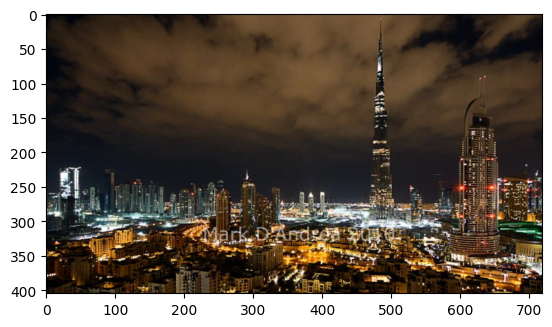

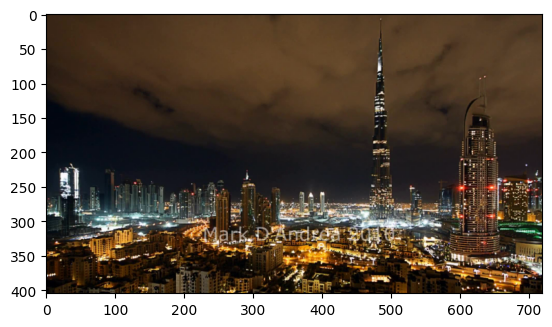

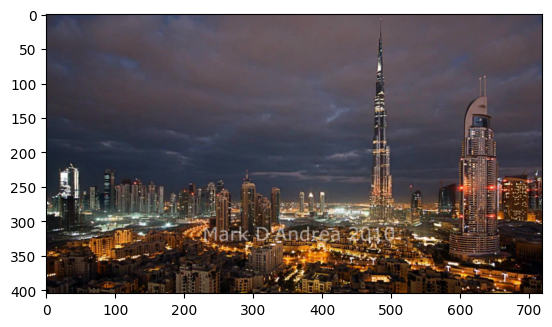

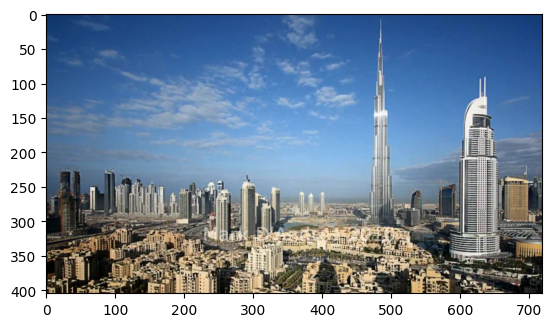

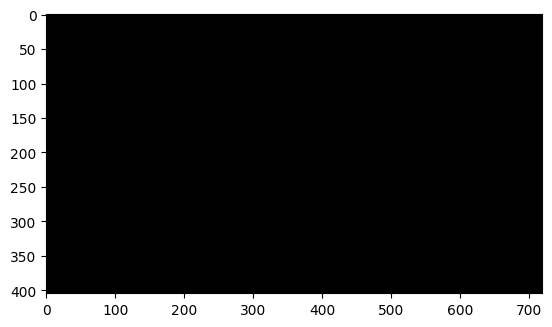

In [23]:
for frame in frames:
    plt.imshow(frame)
    plt.show()

In [24]:
CM_h_t = []
CM_v_t = []

start_time = time.time()

for i in tqdm(range(total_frames_num), desc="Compute Compatibility", ascii=False, ncols=75):
  frame = frames[i]
  all_patches = im2patches3(frame, flags['patch_sz'], flags['interval_sz'])
  temp1, temp2 = ComputeCompatibility(all_patches, candidates, flags)
  CM_h_t.append(temp1)
  CM_v_t.append(temp2)

CM_h_t = np.asarray(CM_h_t)
CM_v_t = np.asarray(CM_v_t)

print("Compute Compatibility:", time.time() - start_time)

Compute Compatibility: 100%|█████████████████| 5/5 [01:17<00:00, 15.53s/it]


Compute Compatibility: 77.93300199508667


In [25]:
num_norm = flags["num_norm"]
if (num_norm == np.Inf):
  CM_h = CM_h_t.max(axis=0)
  CM_h = CM_h**2
  CM_v = CM_v_t.max(axis=0)
  CM_v = CM_v**2

start_time = time.time()

alpha = 3
num_iterations = flags["num_iterations"]
IDX = immaxproduct(CO, CM_h*alpha, CM_v*alpha, num_iterations, 0.5)

print("Belief Propagation:", time.time() - start_time)

Belief Propagation: 16.325000524520874


In [26]:
dim, h, w = Patches.shape
for i in range(h):
  for j in range(w):
    candidates[i][j]["optimal_idx"] = IDX[i, j]

correspondence = candidates

# Local Affine Transfer

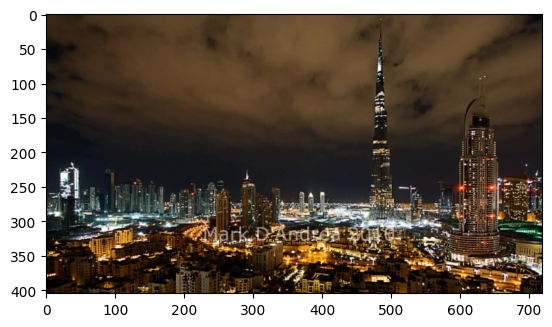

In [27]:
queue = 386
cap = cv2.VideoCapture("dubai.avi")

width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

h_w_ratio = height/width

cap.set(cv2.CAP_PROP_POS_FRAMES, queue)
success, reference_image = cap.read()
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
reference_image = cv2.resize(reference_image, (720, int(720*h_w_ratio)), interpolation=cv2.INTER_AREA)

plt.imshow(reference_image)
plt.show()

### Warp Image

In [28]:
def mergePatches(Patches, overlap_sz, width, height):
  
  nDim, h, w = Patches.shape
  patchDim = int(np.sqrt(nDim/3))
  patch_sz = int((patchDim-1) // 2)
  interval_sz_temp = patch_sz*2 - overlap_sz

  temp_im = np.zeros((height, width, 3))
  weight = np.zeros((height, width, 3))

  foo = np.linspace(0, 1, overlap_sz+2)
  foo = foo[1:-1]

  mask = np.append(foo, np.ones((1, int(patchDim-overlap_sz*2))))
  mask = np.append(mask, np.flip(foo))
  mask = mask.reshape((mask.size, 1))
  
  mask = np.kron(mask, mask.T)
  mask = np.dstack((mask, mask, mask))

  for i in range(h):
    for j in range(w):
      x = j*interval_sz_temp + patch_sz
      y = i*interval_sz_temp + patch_sz
      k = Patches[:, i, j].reshape((int(patchDim), int(patchDim), 3), order='F')
      temp_im[y - patch_sz:y + patch_sz + 1, x - patch_sz:x + patch_sz + 1, :] = temp_im[y - patch_sz:y + patch_sz + 1, x - patch_sz:x + patch_sz + 1, :] + np.multiply(k, mask)
      weight[y - patch_sz:y + patch_sz + 1, x - patch_sz:x + patch_sz + 1, :] = weight[y - patch_sz:y + patch_sz + 1, x - patch_sz:x + patch_sz + 1, :] + mask

  index = (temp_im == 0)
  temp_im = np.divide(temp_im, weight)
  temp_im[index] = 0

  return temp_im

In [29]:
def merge_patches(input_image, correspondence, reference_frame, flags):

  candidates = correspondence.copy()
  patch_sz = flags['patch_sz']
  overlap_sz = flags['overlap_sz']
  interval_sz = flags['interval_sz']

  reference_patches = im2patches3(reference_frame, patch_sz, interval_sz)
  Patches_temp, Mask_temp = extractPatches(input_image, patch_sz, overlap_sz)

  _, h, w = Patches_temp.shape

  for i in range(h):
    for j in range(w):
      idx = candidates[i][j]['idx']
      candidates[i][j]['patches'] = reference_patches[idx, :]

  patches_from_candidates = np.zeros((3*(2*patch_sz+1)**2, h, w))

  for i in range(h):
    for j in range(w):
      optimal_idx = candidates[i][j]['optimal_idx']
      patches_from_candidates[:, i, j] = candidates[i][j]['patches'][optimal_idx, :].T

  height, width, num_channel = input_image.shape
  warped_reference_frame = mergePatches(patches_from_candidates, overlap_sz, width, height);

  return warped_reference_frame

In [30]:
def warpImg(im, warp_field, mode, input_image, flags):
  
  reference_frame = im.copy()
  warpI2 = merge_patches(input_image, warp_field, reference_frame, flags)

  return warpI2

### Affine Transfer

In [31]:
def regularized_linear_regression(input_image, correspondence, typ, reference_frame, best_frame, flags):

  example_field = warpImg(reference_frame, correspondence, typ, input_image, flags)
  warped_best_frame = warpImg(best_frame, correspondence, typ, input_image, flags)

  eng = matlab.engine.start_matlab()
  eng.cd(r'.', nargout=0)
  print("MATLAB engine started")
  
  input_image_mat = matlab.double(input_image.astype(np.float64))
  example_field_mat = matlab.double(example_field)
  warped_best_frame_mat = matlab.double(warped_best_frame)

  transfer_field = eng.getLaplacian(input_image_mat, warped_best_frame_mat, example_field_mat, flags)
  transfer_field = eng.uint8(transfer_field)

  transfer_field = np.array(transfer_field)
  transfer_field = transfer_field.reshape(example_field.shape, order='F')

  return transfer_field

In [32]:
def TransferLocalFeature(input_image, correspondence, typ, reference_frame, best_frame, flags):
  transfer_field = regularized_linear_regression(input_image, correspondence, typ, reference_frame, best_frame, flags)
  return transfer_field

In [33]:
transfer_field = TransferLocalFeature(image, correspondence, typ, reference_image, best_frame, flags)

MATLAB engine started


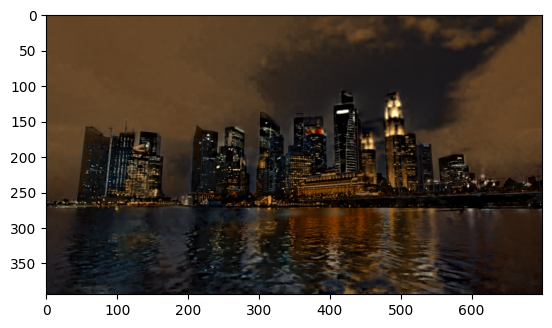

True

In [34]:
output = transfer_field

plt.imshow(output)
plt.show()

cv2.imwrite("output.jpg", cv2.cvtColor(output, cv2.COLOR_RGB2BGR))